In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing Packages
import seaborn as sns
import math 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For specifying the axes tick format 
from scipy.stats import norm, skew #for some statistics
from scipy import stats

#Reading Data
telecom_cust = pd.read_csv('/content/Telco-Customer-Churn.csv')        

<a id="section-one"></a>
# 1. Introduction
## a. Problem Statement
Every time a client leaves a business, it represents a significant investment lost. Being able to predict when a client is likely to leave, and offer them incentives to stay, can offer huge savings to a business. Also, understanding what keeps customers engaged is extremely valuable knowledge, as it can be used to develop retention strategies. 

Here we need to know: “Is this customer going to leave us?” Yes or No? 
It is a **binary classification task**.

## b. Data description
Each row represents a customer; each column contains the following customer’s attributes:
* **Target (Dependent Variable) - Churn** (Definition: Customers who left within the last month)
* **Customer Demographics** – gender, age, and if they have partners and dependents
* **Customer Account Info** – tenure, contract, payment method, paperless billing, monthly charges, and total charges
* **Services Availed** – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

# 2. Data types & missing values

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Sample Value'] = df.loc[0].values
    return summary

In [4]:
resumetable(telecom_cust)

Dataset Shape: (7043, 21)


,Name,dtypes,Missing,Uniques,Sample Value
0,customerID,object,0,7043,7590-VHVEG
1,gender,object,0,2,Female
2,SeniorCitizen,int64,0,2,0
3,Partner,object,0,2,Yes
4,Dependents,object,0,2,No
5,tenure,int64,0,73,1
6,PhoneService,object,0,2,No
7,MultipleLines,object,0,3,No phone service
8,InternetService,object,0,3,DSL
9,OnlineSecurity,object,0,3,No


**Action:** 
* Converting Total Charges to a numerical data type.
* Removing customer IDs from the data set as it is unique to every record and we therefore won't use it as a predictor variable.

In [5]:
#Coverting totalCharges to numerical data type.
telecom_cust.TotalCharges = pd.to_numeric(telecom_cust.TotalCharges, errors='coerce')
#Droppong customer ID
cust = telecom_cust.iloc[:,1:]

**Action :**
Checking for missing values after changing the data type.

In [6]:
cust.TotalCharges.isna().sum()

11

## Handling Missing Values

In [7]:
cust[cust.TotalCharges.isna()][['tenure','MonthlyCharges','TotalCharges','Churn']]

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No


**Observation**: All the new customers(i.e. tenure=0 months) have no total charges data available.

**Action**: We would drop these rows here as all of them have been in the system for less than a month and Customers are marked as churned if they have left the system in the last one month.

In [8]:
#Removing missing values
cust.dropna(inplace = True)

# 3. EDA and Data Prepocessing

## a. Correlation of the features with Churn
* Convert the target variable in a binary numeric variable
* Convert all Categorical variables into dummy variables

In [9]:
cust['Churn'].replace(to_replace='Yes', value=1, inplace=True)
cust['Churn'].replace(to_replace='No',  value=0, inplace=True)
cust_dummies = pd.get_dummies(cust)

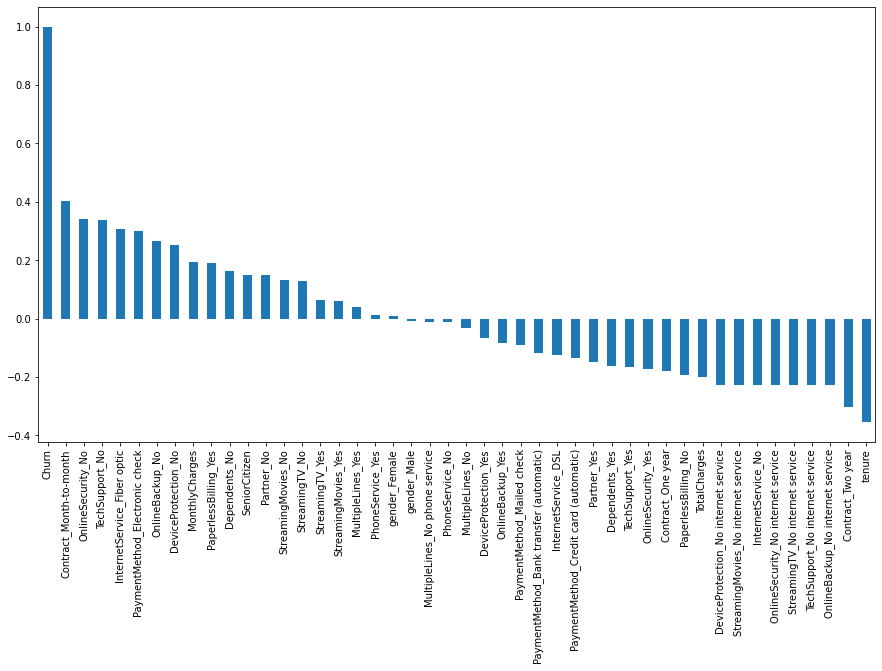

In [10]:
plt.figure(figsize=(15,8))
cust_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

**Observation**:
* Month to month contracts, absence of online security and tech support seem to be positively correlated with churn. 
* Tenure, two year contracts seem to be negatively correlated with churn.
* Interestingly, services such as Online security, Online backup, Tech support and others without internet connection seem to be negatively related to churn.

## b. Distribution of Numerical Variables

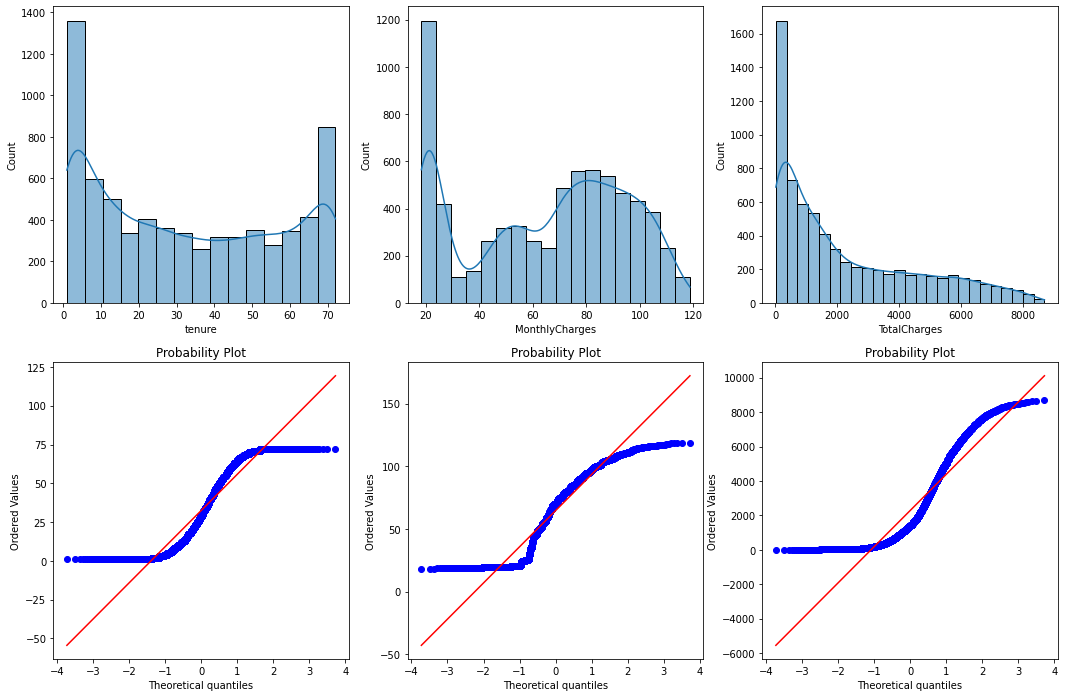

In [11]:
plot , ax = plt.subplots(2 , 3 , figsize = (18 , 12))
data_norm=cust[['tenure', 'MonthlyCharges', 'TotalCharges']]
g = sns.histplot(cust['tenure'] , kde = True , ax = ax[0][0])
res = stats.probplot(cust['tenure'], plot= ax[1][0])
g = sns.histplot(cust['MonthlyCharges'] , kde = True , ax = ax[0][1])
res = stats.probplot(cust['MonthlyCharges'], plot= ax[1][1])
g = sns.histplot(cust['TotalCharges'] , kde = True , ax = ax[0][2])
res = stats.probplot(cust['TotalCharges'], plot= ax[1][2])

**Observation :**
* Tenure is following a **Bimodal distribution**
* MonthlyCharges is following **Edge Peak distribution**
* TotalCharges is following **Right Skewed distribution**

These numerical variables are not following a normal distribution. These distributions indicate there are different data distributions present in population data with separate and independent peaks.

**Action :**

Check if the different classes of the target variable represents the different distribution present in the data.

## c. Distribution of Categorical Variables

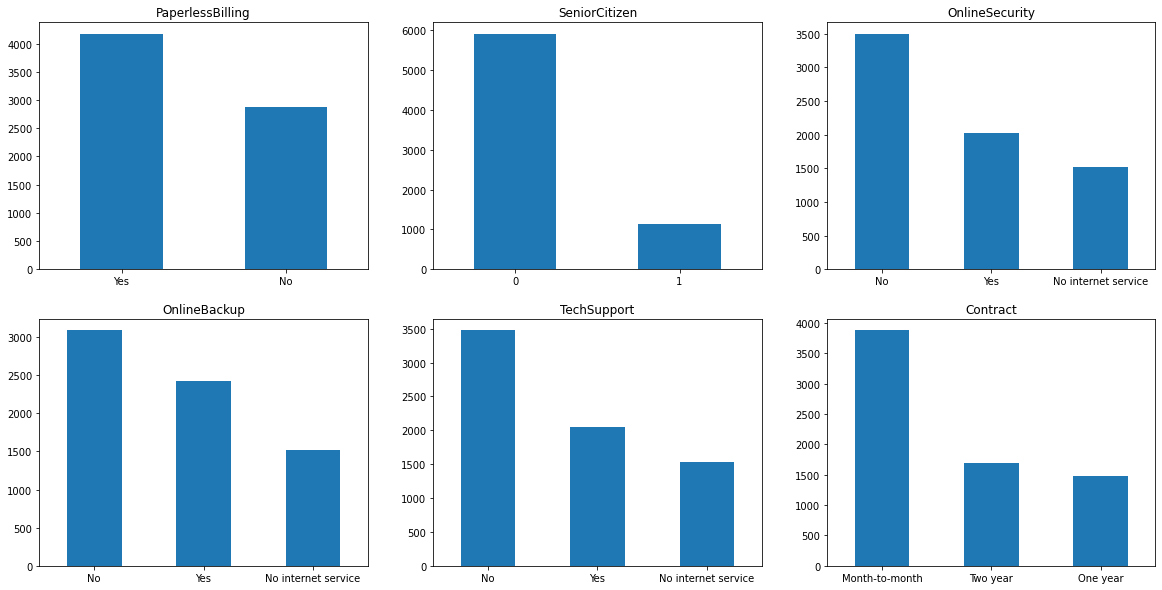

In [12]:
cat_cols = ['PaperlessBilling','SeniorCitizen','OnlineSecurity','OnlineBackup','TechSupport','Contract']

fig, axes = plt.subplots(nrows = 2,ncols = 3,figsize = (20,10))
for i, item in enumerate(cat_cols):
    if i < 3:
        ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[0,i],rot = 0)
        
    elif i >=3 and i < 6:
        ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[1,i-3],rot = 0)
        
    ax.set_title(item)

## d. Visualizing the important variables along with target variable.

**Churn by Tenure**: Recent clients are more likely to churn.

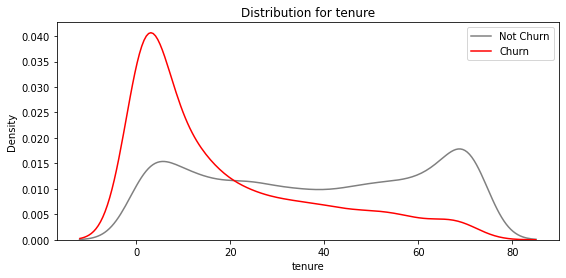

In [13]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("Distribution for {}".format(feature))
    ax0 = sns.kdeplot(cust[cust['Churn'] == 0][feature].dropna(), color= 'grey', label= 'Churn: No')
    ax1 = sns.kdeplot(cust[cust['Churn'] == 1][feature].dropna(), color= 'Red', label= 'Churn: Yes')
    ax0.legend(["Not Churn","Churn"],loc='upper right')
kdeplot('tenure')

**Churn by Monthly Charges**: Clients with higher MonthlyCharges are more likely to churn.

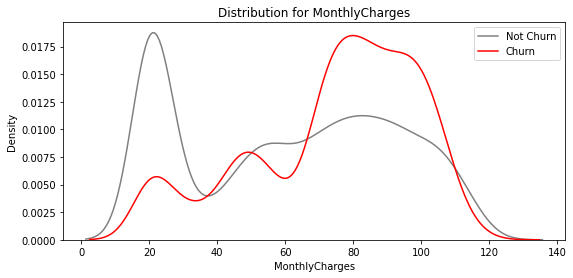

In [14]:
kdeplot('MonthlyCharges')

**Churn by Total Charges**: It seems that there is higer churn when the total charges are lower.

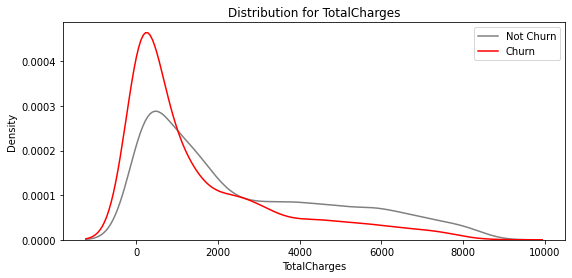

In [15]:
kdeplot('TotalCharges')

**Churn by Contract Type**: The customers who have a month to month contract have a very high churn rate, similar to the correlation plot.

In [16]:
def stack_dist(feature):
    colors = ['grey','red']
    contract_churn = cust.groupby([feature,'Churn']).size().unstack()

    ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar', width = 0.3, stacked = True, rot = 0, figsize = (10,6), color = colors)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(loc='best',prop={'size':14},title = 'Churn')
    ax.set_ylabel('% Customers',size = 14)
    ax.set_title('Churn by {}'.format(feature),size = 14)

    # Code to add the data labels on the stacked bar chart
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                    color = 'white',
                   weight = 'bold',
                   size = 14)

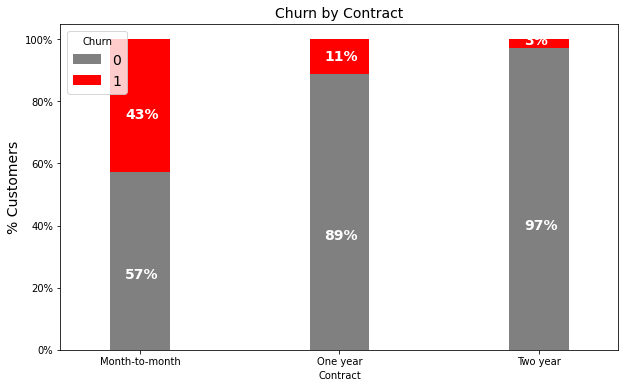

In [17]:
stack_dist('Contract')

**Churn by Online Security**: Customer having no Online Security have a higher probability of Churn.

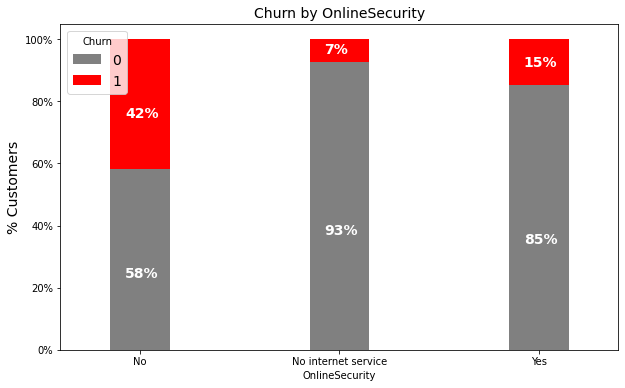

In [18]:
stack_dist('OnlineSecurity')

**Churn by Paperless Billing**: Customer having Paperless Billing service have a higher probability of Churn.

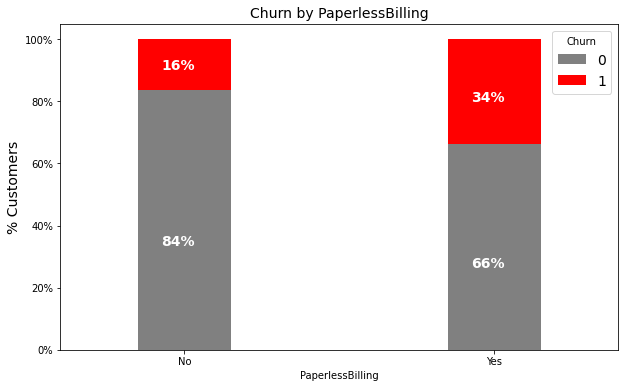

In [19]:
stack_dist('PaperlessBilling')

**Churn by Tech Support**: Customer having no Tech Support have a higher probability of Churn.

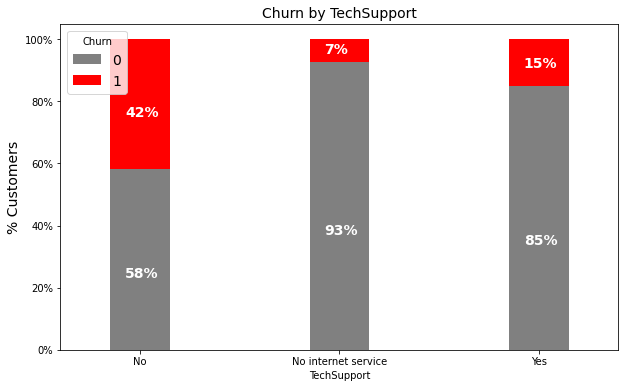

In [20]:
stack_dist('TechSupport')

**Churn by Online Backup**: Customer having no Online Backup have a higher probability of Churn.

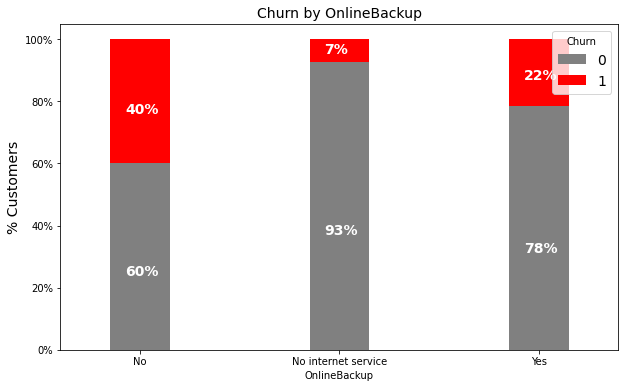

In [21]:
stack_dist('OnlineBackup')

**Churn by Seniority**: Senior Citizens have higher churn rate than younger population.

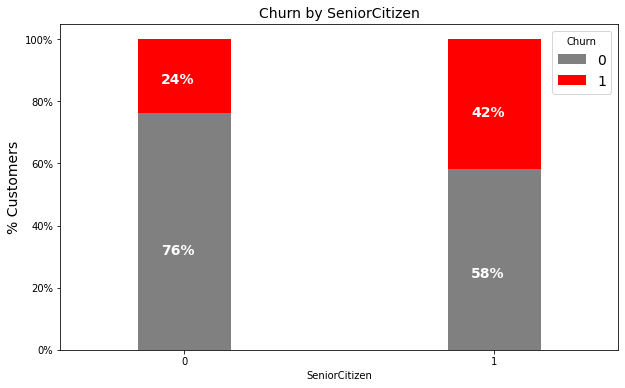

In [22]:
stack_dist('SeniorCitizen')

**Feature Selection**

Based on the correlation we would select the following features to begin with:
* Tenure
* Monthly Charges
* Total Charges
* Contract
* PaperlessBilling
* SeniorCitizen
* OnlineSecurity
* Tech Support
* OnlineBackup

In [23]:
#selecting the predictor variables
pred=pd.get_dummies(cust[['PaperlessBilling','SeniorCitizen','OnlineSecurity','OnlineBackup','TechSupport','tenure','TotalCharges','Contract','MonthlyCharges']])
Churn=cust['Churn']

## e. Multicolinearity
Checking if predictor variables are independent of each other

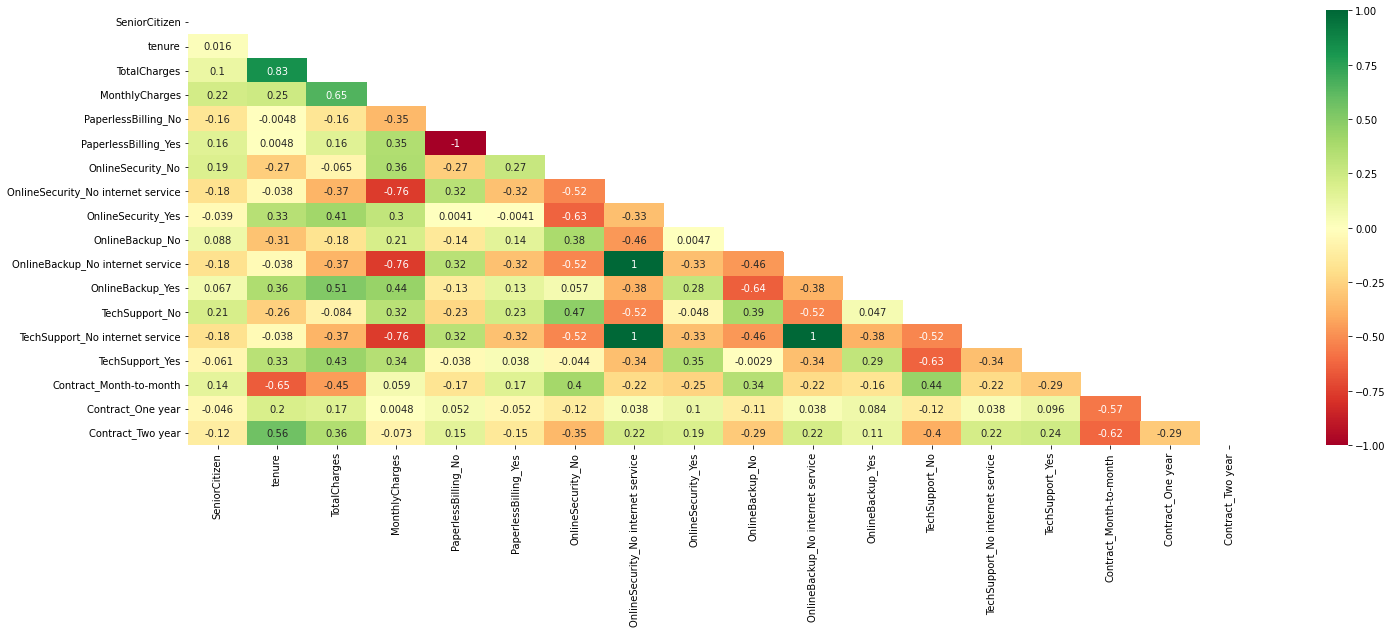

In [24]:
#the heat map of the correlation
plt.figure(figsize=(24,8))
corr = pred.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdYlGn')

**Observation :**
Multicolinearity exists, as a lot of features are highly correlated to each other


**Action :**
Checking the relation between some of the highly correlated features.
Dropping some dummy variables created from Categorical variables 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Two Year Contract')

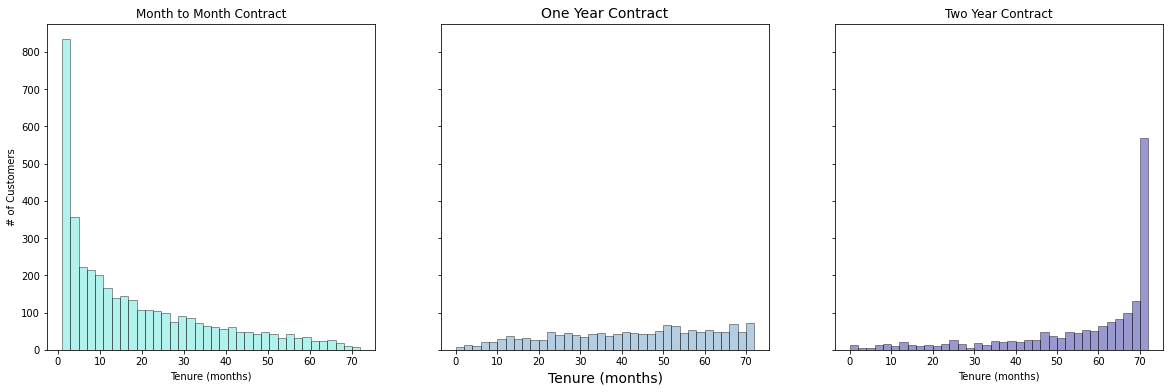

In [25]:
#Plotting Contract and Tenure
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

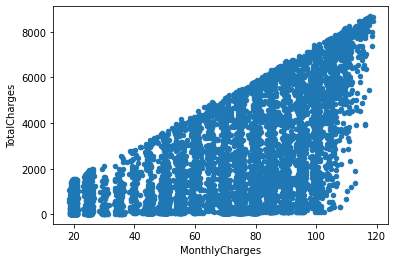

In [26]:
#plotting Monthly Charges against Total Charges
telecom_cust[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',y='TotalCharges')

In [27]:
#dropping dependent dummy variables
pred.drop(columns=['OnlineSecurity_No internet service','TechSupport_No internet service','OnlineBackup_No internet service','Contract_Two year','PaperlessBilling_No','OnlineBackup_No'],inplace=True)
#Adding target variable to check the ranges
pred['churn']=Churn

## f. Checking the ranges of the Predictor Variables

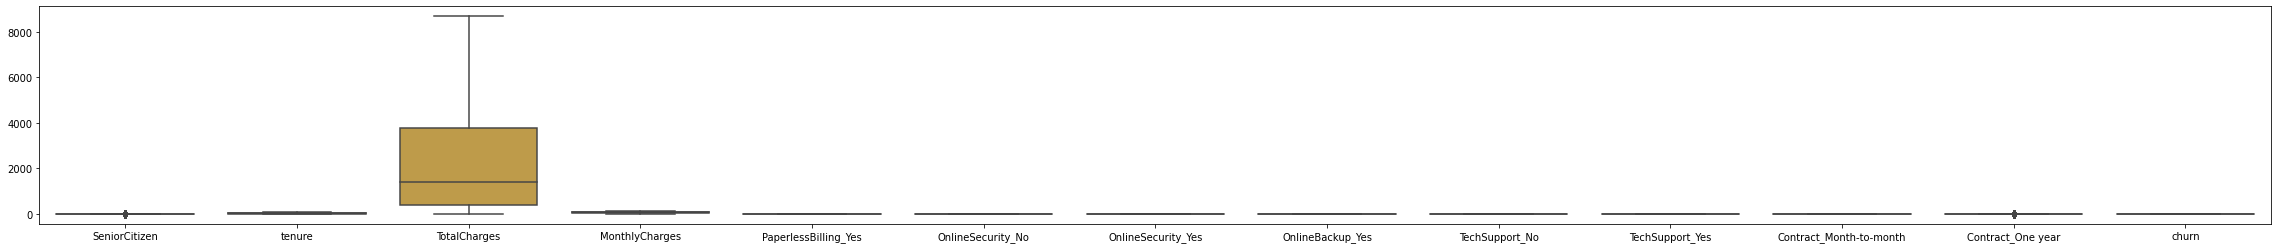

In [28]:
plt.figure(figsize=(40,4))
sns.boxplot(data=pred)

**Action :**

As the scale of Total Charges is very high we will scale the range of all the variables between 0 to 1.

In [29]:
# Scaling all the variables to a range of 0 to 1 using Min Max Scaler
from sklearn.preprocessing import MinMaxScaler
features = pred.columns.values
scaler = MinMaxScaler()
scaler.fit(pred)
pred = pd.DataFrame(scaler.transform(pred))
pred.columns = features

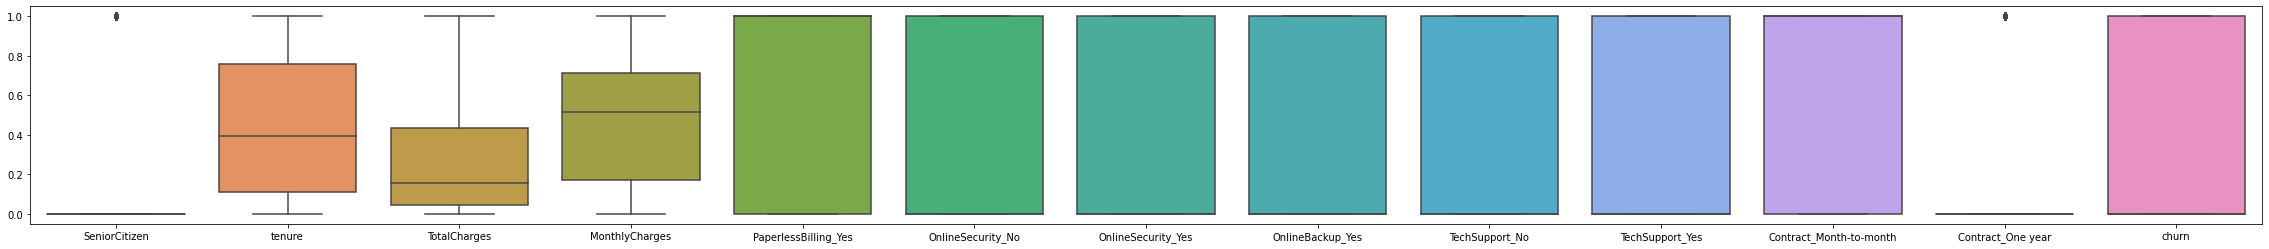

In [30]:
plt.figure(figsize=(40,4))
sns.boxplot(data=pred)

In [31]:
Churn=pred['churn']
pred.drop(columns='churn',inplace=True)

## g. OLS Regression
**Ordinary Least Squares regression (OLS)** is a common technique for estimating coefficients of linear regression equations which describe the relationship between one or more independent quantitative variables and a dependent variable (simple or multiple linear regression).

In [32]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(Churn, pred).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  churn   R-squared (uncentered):                   0.463
Model:                            OLS   Adj. R-squared (uncentered):              0.462
Method:                 Least Squares   F-statistic:                              550.2
Date:                Mon, 10 Oct 2022   Prob (F-statistic):                        0.00
Time:                        03:22:36   Log-Likelihood:                         -3133.2
No. Observations:                7032   AIC:                                      6288.
Df Residuals:                    7021   BIC:                                      6364.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
SeniorCitizen               0.0589      0.013      4.607      0.000       0.034       0.084
tenure                      0.0084      0.023      0.362      0.717      -0.037       0.054
TotalCharges               -0.5332      0.050    -10.769      0.000      -0.630      -0.436
MonthlyCharges              0.5636      0.034     16.400      0.000       0.496       0.631
PaperlessBilling_Yes        0.0592      0.010      5.928      0.000       0.040       0.079
OnlineSecurity_No           0.0478      0.011      4.483      0.000       0.027       0.069
OnlineSecurity_Yes         -0.0402      0.011     -3.772      0.000      -0.061      -0.019
OnlineBackup_Yes           -0.0473      0.011     -4.160      0.000      -0.070      -0.025
TechSupport_No              0.0460      0.011      4.373      0.000       0.025       0.067
TechSupport_Yes            -0.0384      0.011     -3.537      0.000      -0.060      -0.017
Contract_Month-to-month     0.1492      0.012     12.000      0.000       0.125       0.174
Contract_One year           0.0051      0.012      0.411      0.681      -0.019       0.030
==============================================================================
Omnibus:                      357.159   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              372.963
Skew:                           0.532   Prob(JB):                     1.03e-81
Kurtosis:                       2.624   Cond. No.                     4.99e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.66e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Observation :**

We will considering the significance value of 0.05.

All the predictor variables except One year contracrts have a p-value less than 0.05 and hence they are significant features.

# 4. Creating Training and Test Sets

In [33]:
#Setting the target label and predictor variables
y = Churn.values
X = pred.copy()

# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Action :** Checking the distribution of train and test sets

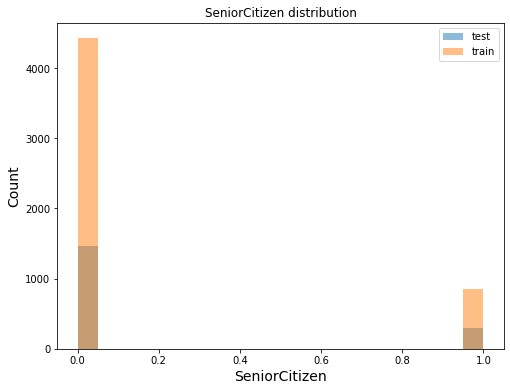

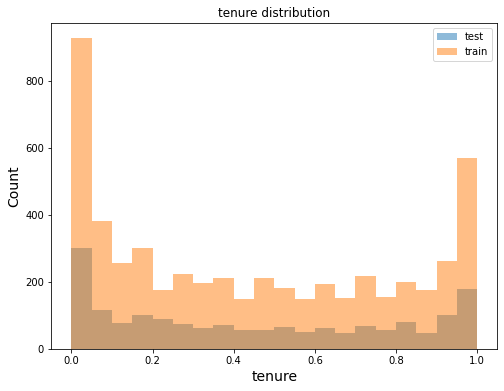

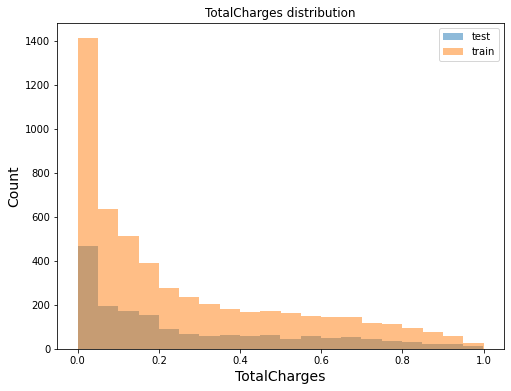

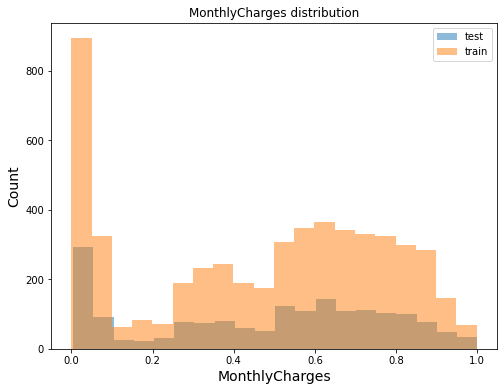

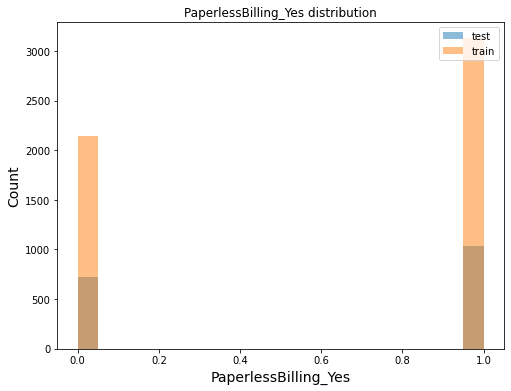

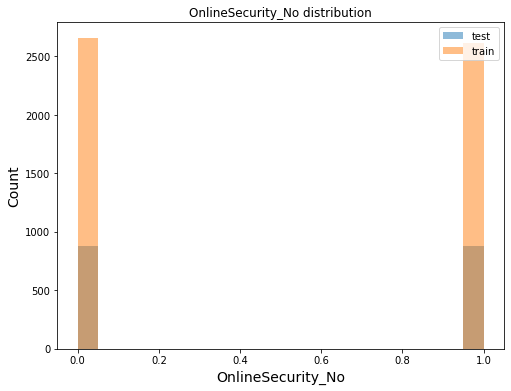

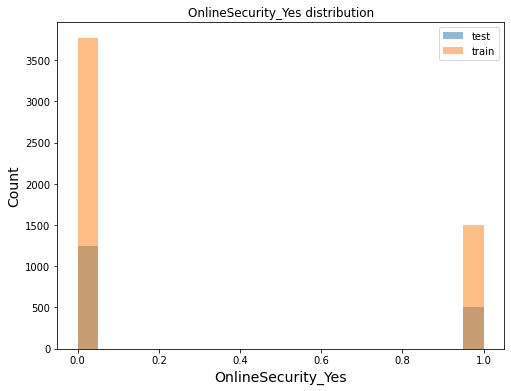

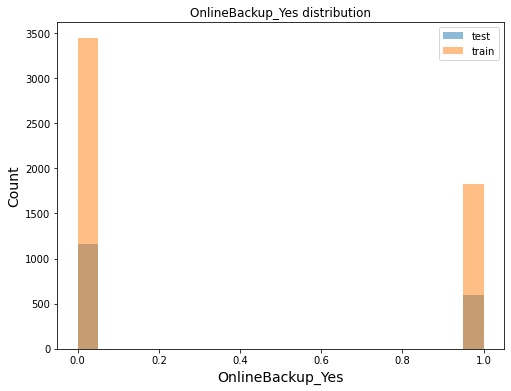

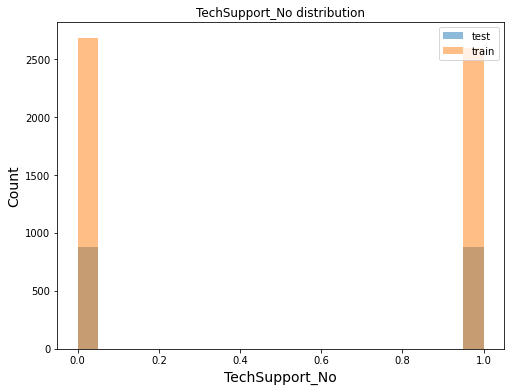

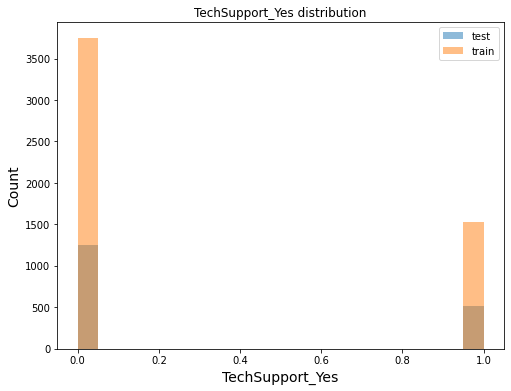

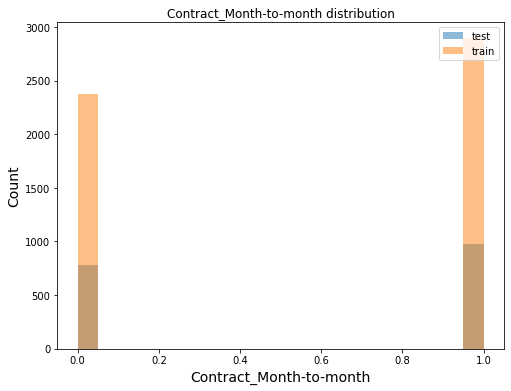

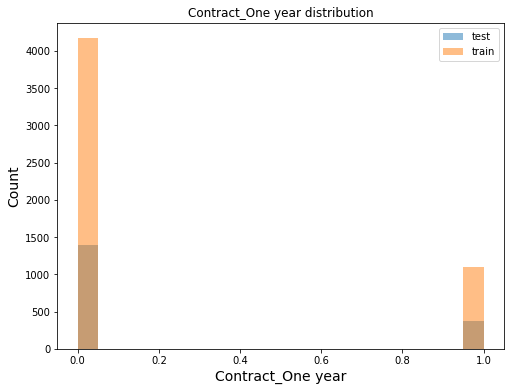

In [34]:
# Looking the data for training and test set
X_test_plot = X_test.copy()
X_train_plot = X_train.copy()

# Plotting the data to see the histogram
for c in X_test_plot.columns[:]:
  plt.figure(figsize=(8,6))
  plt.hist(X_test_plot[c], bins=20, alpha=0.5, label="test")
  plt.hist(X_train_plot[c], bins=20, alpha=0.5, label="train")
  plt.xlabel(c, size=14)
  plt.ylabel("Count", size=14)
  plt.legend(loc='upper right')
  plt.title("{} distribution".format(c))
  plt.show()

# 5. Running a Logistic Regression Model

In [35]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

# Print the prediction accuracy
from sklearn import metrics
prediction_test = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.7935153583617748


In [36]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.0 MB/s 
     |████████████████████████████████| 133 kB 54.3 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=cd018c8623bbb47b2d46d0009b63ffebe6502794e09311c4c37ed4636c184dad
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [37]:
#Understanding the important features 
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0844 ± 0.0200,tenure
0.0328 ± 0.0084,Contract_Month-to-month
0.0259 ± 0.0095,MonthlyCharges
0.0090 ± 0.0086,TotalCharges
0.0057 ± 0.0057,PaperlessBilling_Yes
0.0056 ± 0.0082,Contract_One year
0.0017 ± 0.0025,TechSupport_No
0.0003 ± 0.0034,OnlineBackup_Yes
-0.0005 ± 0.0066,SeniorCitizen
-0.0022 ± 0.0086,TechSupport_Yes


**Observation :**

Tenure,  Contract Types, Monthly Charges and Total Charges are the most prominent features similar to our previous observation. 

# 6. Outlier Detection

As we didn't notice any outliers in the box plots of the predictor variables, we will use One-Class SVM to detect Outliers

In [38]:
from sklearn.svm import OneClassSVM

# identify outliers in the training dataset
ee = OneClassSVM(nu=0.01)
mask = ee.fit_predict(X_train)

X_train_wo_outliers, y_train_wo_outliers = X_train[mask!=-1], y_train[mask!=-1]

#Print outlier count
outlier_count=len(X_train)-len(X_train_wo_outliers)
print("Number of records as outliers : {}".format(outlier_count))

#train
model = LogisticRegression()
result = model.fit(X_train_wo_outliers, y_train_wo_outliers)

# Print the prediction accuracy
from sklearn import metrics
prediction_test = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

Number of records as outliers : 63
0.7923777019340159


**Observation :**

Accuracy with Outliers: 79.35%

Accuracy without Outliers: 79.24%

We see a no significant difference in model performance by eliminating the outliers.

# 7. Imputing missing values in predictor variables

In [39]:
cust_null_1=cust.copy()
cust_null_5=cust.copy()
cust_null_10=cust.copy()

# Creating a list of 1% data and filling with NaN
empty_1=cust_null_1[['Contract','MonthlyCharges']].sample(frac=0.01, replace=True, random_state=1)
cust_null_1.loc[empty_1.index, ['Contract','MonthlyCharges']] = np.NaN

# Creating a list of 5% data and filling with NaN
empty_5=cust_null_5[['Contract','MonthlyCharges']].sample(frac=0.05, replace=True, random_state=1)
cust_null_5.loc[empty_5.index, ['Contract','MonthlyCharges']] = np.NaN

# Creating a list of 10% data and filling with NaN
empty_10=cust_null_10[['Contract','MonthlyCharges']].sample(frac=0.1, replace=True, random_state=1)
cust_null_10.loc[empty_10.index, ['Contract','MonthlyCharges']] = np.NaN

## a. Using Simple Imputer and replacing with most frequent values

In [40]:
#import SimpleImputer
from sklearn.impute import SimpleImputer

#Fill with most frequent
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#For 1%
cust_filled_1=pd.DataFrame(simple_imputer.fit_transform(cust_null_1))
cust_filled_1.columns=cust_null_1.columns
cust_filled_1.index=cust_null_1.index
contract_filled_1=cust_filled_1.iloc[empty_1.index].Contract
monthly_charges_filled_1=cust_filled_1.iloc[empty_1.index].MonthlyCharges

#For 5%
cust_filled_5=pd.DataFrame(simple_imputer.fit_transform(cust_null_5))
cust_filled_5.columns=cust_null_5.columns
cust_filled_5.index=cust_null_5.index
contract_filled_5=cust_filled_5.iloc[empty_5.index].Contract
monthly_charges_filled_5=cust_filled_5.iloc[empty_5.index].MonthlyCharges

#For 10%
cust_filled_10=pd.DataFrame(simple_imputer.fit_transform(cust_null_10))
cust_filled_10.columns=cust_null_10.columns
cust_filled_10.index=cust_null_10.index
contract_filled_10=cust_filled_10.iloc[empty_10.index].Contract
monthly_charges_filled_10=cust_filled_10.iloc[empty_10.index].MonthlyCharges

**Action :** 
Confusion Matrix generated by filling Contract with Most Frequent Values

In [41]:
from sklearn.metrics import confusion_matrix
cm_1=confusion_matrix(empty_1['Contract'], contract_filled_1)
cm_5=confusion_matrix(empty_5['Contract'], contract_filled_5)
cm_10=confusion_matrix(empty_10['Contract'], contract_filled_10)

cm_df_1 = pd.DataFrame(cm_1,index = ['Month-to-month','One year','Two year'],columns = ['Month-to-month','One year','Two year'])
cm_df_5 = pd.DataFrame(cm_5,index = ['Month-to-month','One year','Two year'],columns = ['Month-to-month','One year','Two year'])
cm_df_10 = pd.DataFrame(cm_10,index = ['Month-to-month','One year','Two year'],columns = ['Month-to-month','One year','Two year'])

In [42]:
# For 1% data imputed
cm_df_1

,Month-to-month,One year,Two year
Month-to-month,23,11,9
One year,7,3,2
Two year,9,1,5


In [43]:
# For 5% data imputed
cm_df_5

,Month-to-month,One year,Two year
Month-to-month,117,39,46
One year,46,15,13
Two year,46,14,16


In [44]:
# For 10% data imputed
cm_df_10

,Month-to-month,One year,Two year
Month-to-month,243,65,79
One year,98,30,25
Two year,100,29,34


In [45]:
# Calculation percentage of residual errors
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [47]:
# Percentage of Residual errors at 1%, 5% and 10% data for monthly Charges
MAPE(empty_1['MonthlyCharges'], monthly_charges_filled_1), MAPE(empty_5['MonthlyCharges'], monthly_charges_filled_5), MAPE(empty_10['MonthlyCharges'], monthly_charges_filled_10)

(56.21919146060016, 62.65029812672756, 53.829027512020645)

In [48]:
cust_null_1=cust[['MonthlyCharges','TotalCharges','tenure']].copy()
cust_null_5=cust[['MonthlyCharges','TotalCharges','tenure']].copy()
cust_null_10=cust[['MonthlyCharges','TotalCharges','tenure']].copy()

# Creating a list of 1% data and filling with NaN
empty_1=cust_null_1['MonthlyCharges'].sample(frac=0.01, replace=True, random_state=1)
cust_null_1.loc[empty_1.index, 'MonthlyCharges'] = np.NaN

# Creating a list of 5% data and filling with NaN
empty_5=cust_null_5['MonthlyCharges'].sample(frac=0.05, replace=True, random_state=1)
cust_null_5.loc[empty_5.index, 'MonthlyCharges'] = np.NaN

# Creating a list of 10% data and filling with NaN
empty_10=cust_null_10['MonthlyCharges'].sample(frac=0.1, replace=True, random_state=1)
cust_null_10.loc[empty_10.index, 'MonthlyCharges'] = np.NaN

## b.Using Simple Imputer and replacing using Mean values

In [50]:
#import SimpleImputer
from sklearn.impute import SimpleImputer

#Fill with mean
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#For 1%
cust_filled_1=pd.DataFrame(simple_imputer.fit_transform(cust_null_1))
cust_filled_1.columns=cust_null_1.columns
cust_filled_1.index=cust_null_1.index
monthly_charges_filled_1=cust_filled_1.iloc[empty_1.index].MonthlyCharges

#For 5%
cust_filled_5=pd.DataFrame(simple_imputer.fit_transform(cust_null_5))
cust_filled_5.columns=cust_null_5.columns
cust_filled_5.index=cust_null_5.index
monthly_charges_filled_5=cust_filled_5.iloc[empty_5.index].MonthlyCharges

#For 10%
cust_filled_10=pd.DataFrame(simple_imputer.fit_transform(cust_null_10))
cust_filled_10.columns=cust_null_10.columns
cust_filled_10.index=cust_null_10.index
monthly_charges_filled_10=cust_filled_10.iloc[empty_10.index].MonthlyCharges

In [51]:
# Percentage of Residual errors at 1%, 5% and 10% data for monthly Charges
MAPE(empty_1, monthly_charges_filled_1), MAPE(empty_5, monthly_charges_filled_5), MAPE(empty_10, monthly_charges_filled_10)

(58.823407369335435, 58.01326393197604, 77.21224156256669)

## c. Using KNN Imputer 

In [52]:
#import KNNmputer
from sklearn.impute import KNNImputer

#Fill with most frequent
knn_imputer = KNNImputer(missing_values=np.nan)

#For 1%
cust_filled_1=pd.DataFrame(knn_imputer.fit_transform(cust_null_1))
cust_filled_1.columns=cust_null_1.columns
cust_filled_1.index=cust_null_1.index
monthly_charges_filled_1=cust_filled_1.iloc[empty_1.index].MonthlyCharges

#For 5%
cust_filled_5=pd.DataFrame(knn_imputer.fit_transform(cust_null_5))
cust_filled_5.columns=cust_null_5.columns
cust_filled_5.index=cust_null_5.index
monthly_charges_filled_5=cust_filled_5.iloc[empty_5.index].MonthlyCharges

#For 10%
cust_filled_10=pd.DataFrame(knn_imputer.fit_transform(cust_null_10))
cust_filled_10.columns=cust_null_10.columns
cust_filled_10.index=cust_null_10.index
monthly_charges_filled_10=cust_filled_10.iloc[empty_10.index].MonthlyCharges

In [53]:
MAPE(empty_1, monthly_charges_filled_1), MAPE(empty_5, monthly_charges_filled_5), MAPE(empty_10, monthly_charges_filled_10)

(13.53477625879311, 7.4258746525518715, 6.755802787743106)

** Observation :**

KNN imputer gives very small residual errors compared to standar imputer using mean and most frequent

# Answers
Questions:
* What are the data types?

Ans -> The data types are integer, float and object.

* Are there missing values?

Ans -> Yes there are missing values.

* What are the likely distributions of the numeric variables?

Ans -> 
Tenure is following a Bimodal distribution
MonthlyCharges is following Edge Peak distribution
TotalCharges is following Right Skewed distribution

* Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods)

Ans -> The important variables are Tenure
Monthly Charges
Total Charges
Contract
PaperlessBilling
SeniorCitizen
OnlineSecurity
Tech Support
OnlineBackup.

* Which independent variables have missing data? How much? 

Ans -> Total Charges have missing values. 11 records are missing.

* Do the training and test sets have the same data?

Ans -> We have divided the entire data frame into a 75-25 split as that would give us more than 1500 records to make the results obtained on the test datasets reliables. As, we have used train_test_split from sklearn.model_selection, the train and test data sets follow the same ditribution.

* In the predictor variables independent of all the other predictor variables?

Ans -> No, multicolinearity exists in the data.

* Which predictor variables are the most important?

Ans -> Tenure
Monthly Charges
Total Charges
Contract
PaperlessBilling
SeniorCitizen
OnlineSecurity
Tech Support
OnlineBackup

* Do the ranges of the predictor variables make sense?

Ans -> The ranges of the predictor variable has been normalized as some predictors like Total Charges had comparatively higher numrical values.

* What are the distributions of the predictor variables?   

Ans -> The distributions of the ategorical variables have been plotted above.
Tenure is following a Bimodal distribution
MonthlyCharges is following Edge Peak distribution
TotalCharges is following Right Skewed distribution

* Remove outliers and keep outliers (does if have an effect of the final predictive model)?

Ans -> We used one class SVM to detect outliers present in the model. There's no significant change in the Final Predictive Model.(i.e. 79.35% to 79.24%)

* Remove 1%, 5%, and 10% of your data randomly and impute the values back using at least 3 imputation methods. How well did the methods recover the missing values?  That is remove some data, check the % error on residuals for numeric data and check for bias and variance of the error. For categorical data, calculate the accuracy and a confusion matrix.

Ans -> KNN imputer recovered the missing values with least residual error compared to replacing values by Most Frequent value and Mean Value

# License

**References**
* Sckit learn offcial documentation
* INFO_6105/ML_Data_Cleaning_and_Feature_Selection/6105_ML_Data_Cleaning_and_Feature_Selection_Abalone_Example/ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb by AI Skunk

Copyright (c) 2022 chakraborty-arnab

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.